In [2]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [3]:
!pip install torch torchvision


--- Round 1/10 ---
Invited clients this round: [0, 1, 2, 3, 4]
Client 0 training time: 3.53 seconds
Client 1 training time: 1.87 seconds
Client 2 training time: 1.88 seconds
Reached target number of completed clients (3). Proceeding to aggregation.
3 out of 5 invited clients completed training.
Accuracy: 0.4396, F1 Score: 0.4092, Loss: 2.0320

--- Round 2/10 ---
Invited clients this round: [1, 2, 0, 3, 4]
Client 1 training time: 2.81 seconds
Client 2 training time: 1.89 seconds
Client 0 training time: 1.89 seconds
Reached target number of completed clients (3). Proceeding to aggregation.
3 out of 5 invited clients completed training.
Accuracy: 0.5644, F1 Score: 0.5576, Loss: 1.6576

--- Round 3/10 ---
Invited clients this round: [2, 1, 0, 3, 4]
Client 2 training time: 1.89 seconds
Client 1 training time: 1.91 seconds
Client 0 training time: 2.57 seconds
Reached target number of completed clients (3). Proceeding to aggregation.
3 out of 5 invited clients completed training.
Accuracy: 0

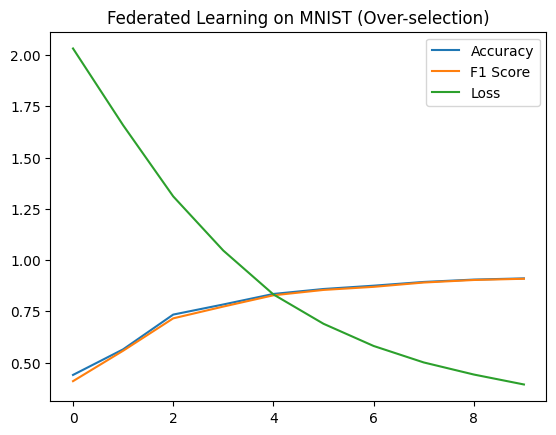

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, F1Score
from torchvision import datasets, transforms
from copy import deepcopy
import numpy as np
import torchvision.models as models
from tqdm.autonotebook import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import time
import random

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def resnet18(num_classes, **kwargs):
    original_model = models.resnet18(**kwargs)
    original_model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    original_model.maxpool = nn.Identity()
    original_model.fc = nn.Linear(512, num_classes)
    return original_model

def uniform_allocation(Y, num_clients):
    indices = np.arange(len(Y))
    np.random.shuffle(indices)
    indices_split = np.array_split(indices, num_clients)
    return [list(idx) for idx in indices_split]

# Hyperparameters
num_clients = 5
batch_size = 64
global_epochs = 10
local_epochs = 2
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()

# Over-selection parameters
num_clients_invited = 5  # Invite more clients than needed
num_clients_target = 3   # Target number of clients to wait for

# Model
model = resnet18(10)
client_models = [deepcopy(model).to(device) for _ in range(num_clients)]
client_optims = [optim.SGD(cm.parameters(), lr=learning_rate) for cm in client_models]

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_dataset.data = train_dataset.data[:5000]
train_dataset.targets = train_dataset.targets[:5000]
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_subsets = uniform_allocation(train_dataset.targets, num_clients)
train_subsets = [torch.utils.data.Subset(train_dataset, indices) for indices in train_subsets]
train_subset_dataloaders = [DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in train_subsets]
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def fed_avg(models):
    avg_model = deepcopy(models[0]).to(device)
    avg_state_dict = avg_model.state_dict()
    with torch.no_grad():
        for key in avg_state_dict.keys():
            if not avg_state_dict[key].dtype.is_floating_point:
                avg_state_dict[key].copy_(models[0].state_dict()[key])
                continue
            tmp = torch.zeros_like(avg_state_dict[key])
            for m in models:
                tmp += m.state_dict()[key]
            avg_state_dict[key].copy_(tmp / len(models))
    return avg_model

# client performance
client_times = [0.0 for _ in range(num_clients)]
client_counts = [0 for _ in range(num_clients)]

global_model = deepcopy(model).to(device)
acc_list, f1_list, loss_list = [], [], []

for round in range(global_epochs):
    print(f"\n--- Round {round+1}/{global_epochs} ---")

    # Select clients to invite based on performance (e.g., fastest)
    avg_times = [
        client_times[i] / client_counts[i] if client_counts[i] > 0 else float('inf')
        for i in range(num_clients)
    ]
    # Sort clients by average time and select the top `num_clients_invited`
    invited_clients_indices = sorted(range(num_clients), key=lambda i: avg_times[i])[:num_clients_invited]
    print(f"Invited clients this round: {invited_clients_indices}")

    participating_clients = []
    completed_clients_count = 0

    # Simulate client training and reporting.
    for i in invited_clients_indices:
        client_models[i].load_state_dict(global_model.state_dict())
        client_models[i].train()
        start_time = time.time()

        # Simulated straggler
        straggler_delay = random.uniform(1.5, 3) if random.random() < 0.4 else 0

        try:
            for epoch in range(local_epochs):
                for x, y in train_subset_dataloaders[i]:
                    # Simulate slow clients
                    if straggler_delay:
                        time.sleep(straggler_delay / (local_epochs * len(train_subset_dataloaders[i])))

                    x, y = x.to(device), y.to(device)
                    client_optims[i].zero_grad()
                    y_pred = client_models[i](x)
                    loss = loss_fn(y_pred, y)
                    loss.backward()
                    client_optims[i].step()

            participating_clients.append(client_models[i])
            completed_clients_count += 1
            end_time = time.time()
            print(f"Client {i} training time: {end_time - start_time:.2f} seconds")
            client_times[i] += end_time - start_time
            client_counts[i] += 1

        except Exception as e: # Catch potential errors during training
            print(f"Client {i} failed during training: {e}")

        # Check if target number of clients have completed
        if completed_clients_count >= num_clients_target:
            print(f"Reached target number of completed clients ({num_clients_target}). Proceeding to aggregation.")
            break # Stop waiting for more clients in this round

    print(f"{completed_clients_count} out of {len(invited_clients_indices)} invited clients completed training.")

    if participating_clients:
        global_model.load_state_dict(fed_avg(participating_clients).state_dict())
    else:
        print("No clients completed training in this round.")

    global_model.eval()
    correct, total, test_loss = 0, 0, 0
    y_true, y_pred_all = [], []

    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            logits = global_model(x)
            loss = loss_fn(logits, y)
            test_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            y_true.extend(y.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    acc = correct / total
    f1 = f1_score(y_true, y_pred_all, average='macro')
    acc_list.append(acc)
    f1_list.append(f1)
    loss_list.append(test_loss / len(test_dataloader))

    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, Loss: {loss_list[-1]:.4f}")

plt.plot(acc_list, label="Accuracy")
plt.plot(f1_list, label="F1 Score")
plt.plot(loss_list, label="Loss")
plt.legend()
plt.title("Federated Learning on MNIST (Over-selection)")
plt.show()


#Federated Learning with Over-Selection

---

## Understanding Federated Learning with Over-Selection

This notebook demonstrates a simulated Federated Learning (FL) setup, focusing on a technique called **over-selection** to mitigate the impact of "stragglers" (clients that are slow or fail). The core idea is to invite more clients than needed for aggregation and proceed as soon as a target number of clients complete their tasks.

The simulation will walk through the following steps, which are repeated for a specified number of **global epochs** (also known as communication rounds):

### 1. Initialization

* **Model Definition:** We start by defining a neural network model. For this simulation, we'll use a modified **ResNet-18** architecture.
* **Client Setup:** A set of "clients" are created, each initially holding a copy of the global model's architecture.
* **Data Distribution:** The **MNIST training data** is partitioned and distributed among these clients, ensuring each client has its own local dataset.
* **Global Model:** A central global model is initialized. This model will be progressively updated over each communication round.
* **Hyperparameters:** Key parameters for the simulation are set, including:
    * `num_clients`: The total number of clients available in the system.
    * `local_epochs`: The number of training epochs each client performs locally.
    * `learning_rate`: The learning rate for local client training.
    * `num_clients_invited`: The number of clients selected to participate in a given round.
    * `num_clients_target`: **Crucially**, this is the minimum number of clients whose updates the server will wait for before proceeding to aggregation. This value will be less than `num_clients_invited` to enable over-selection.

### 2. Client Selection (with Over-Selection)

* In each global round, a subset of clients is chosen to participate.
* Instead of inviting exactly `num_clients_target` clients, the system invites **more clients** (`num_clients_invited > num_clients_target`).
* In this specific simulation, client selection prioritizes the **fastest clients** based on their historical average training time. This aims to further optimize for timely completions.

### 3. Global Model Distribution

* The current state of the global model's parameters is distributed to all the `num_clients_invited` selected clients.

### 4. Local Training (with Straggler Simulation)

* Each invited client performs local training on its own unique dataset for `local_epochs`.
* To simulate real-world scenarios, the code introduces **random delays** during client training, mimicking the behavior of "stragglers" (clients that take longer to complete their tasks).

### 5. Waiting and Aggregation (Leveraging Over-Selection)

* The server (simulated within the code) monitors the invited clients, waiting for them to complete their local training and send back their updated models.
* This is where the power of over-selection comes into play: The server **does not wait for all `num_clients_invited` clients**. As soon as `num_clients_target` clients successfully complete their training and transmit their model updates, the server stops waiting.
* Any clients that are still training or fail after this point are effectively "ignored" for the current round's aggregation, allowing the process to continue without being bottlenecked by slow participants.
* The server then aggregates the models received from the **completed clients** using the **Federated Averaging (FedAvg)** algorithm. This typically involves averaging the model parameters.

### 6. Global Model Update

* The global model's parameters are updated using the aggregated parameters from the completed clients. This new global model will be used in the next communication round.

### 7. Evaluation

* After each global round, the newly updated global model's performance is evaluated on a separate, unseen **test set**.
* Metrics such as **accuracy, F1 score, and loss** are tracked to monitor the training progress and the effectiveness of the FL process.

### 8. Iteration

* Steps 2 through 7 are repeated for the total specified number of `global_epochs`.

### 9. Visualization

* Finally, the notebook will generate plots to visualize how the performance metrics (accuracy, F1 score, loss) evolve over the global rounds, providing insights into the training stability and convergence.

---
